# Computational Methods in Simulation (CMIS) Week 4
This notebook is intended to support your learning process. It contains exercises that help you to understand the material. 

This week is based on Slides 19 - follow the detailed steps below to learn about the finite element method:

* 1D Poisson Problem
    * Make an implementation of the 1D example. Use the values $x_1 = 1$, $x_n = 2$, $\Delta x = 0.1$, $a = 1$, $b = 2$, $c = 0$.
    * Start by making a sketch on paper showing how you expect $y(x)$ to look like.
    * Discuss which parts of the algorithm that is embarrassingly parallel. 
    * If you have extra time consider rewriting the parts that have race conditions to become embarrassingly parallel.
    * Consider using an iterative method (like Conjugate Gradient) for solving the reduced system, can you suggest any optimizations? (Hint: do not actually assemble the global matrix)


* 2D Poisson Problem
    * Derive the formula for $K_e$ and $f_e$ in full detail for the 2D example.
    * Make an implementation of the 2D example on a rectangular domain that is 6-by-2 in size.
    * Set $a = 1$ on the left edge of the rectangle and $a = 2$ on the right size.
    * Use $c = 0$
    * Treat boundary conditions as point wise conditions
    * Discuss from a computer scientist viewpoint which steps are the same and which steps that are different compared to the 1D example.

## Detailed Expected Learning Objectives of this Week

* Finite Element Method (FEM) Part 1 (Slides 19)
    * Explain the steps of the FEM method.
    * Account for terminology such as trial and shape/basis functions.
    * Explain the consequence of changing grid spacing, especially from uniform to non-uniform grid spacing, within the FEM method and why one would choose one or the other
    * Apply the steps of FEM method from simple 1D and/or 2D problems like Heat diffusion.
    * Apply experimental verification to ones implementation of a FEM.

In [1]:
%matplotlib widget

In [2]:
import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt

# The 1D Poisson Problem solved with Linear Finite Element Method

We first compute an array Ke of local elementwise values. Aftewards we assemble the local values into a global martix and vector. First we ignore boundary conditions and simply just fill in values. We expect to have one-zero eigenvalue of this type of problem as we have not yet added boundary conditions. Due to precision and round-off errors the numerical computed eigenvalues may not be exactly zero but close to machine epsilon.

In [3]:
dx = 0.1
x  = np.linspace(1.0, 2.0, 10)
N  = len(x)
Ke = np.zeros((N-1, 2, 2),dtype=np.float64)  
K  = np.zeros((N,N),dtype=np.float64)
f  = np.zeros((N,),dtype=np.float64)

# Very parallellizable
for e in range(N-1):
    i = e
    j = i+1
    
    # TODO - compute Ke
    Ke[e] = np.array([[1, -1],[-1, 1]])/(x[i+1]-x[i])


# Defining the 1d T-matrix
T = np.array([[i, i+1] for i in range(N-1)])

for e in range(N-1):
    i, j = T[e]
    # TODO - Assemble Ke into global K
    K[i:i+2, i:i+2] += Ke[e]

Before doing more we want to verify if the assembly process was done correctly. We do this by studying the matrix fill pattern and the eigenvalue spectrum. 

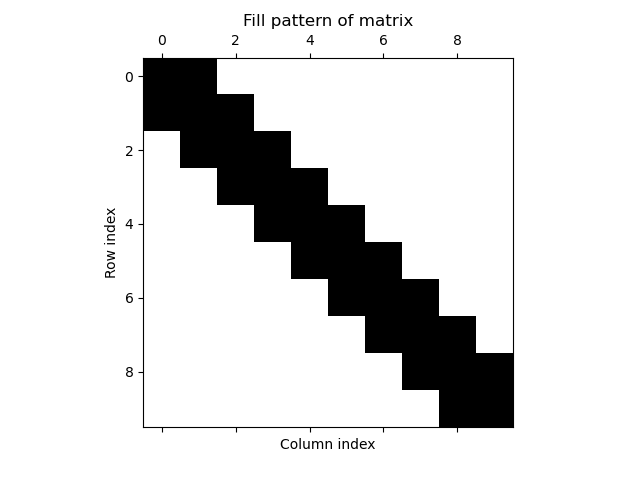

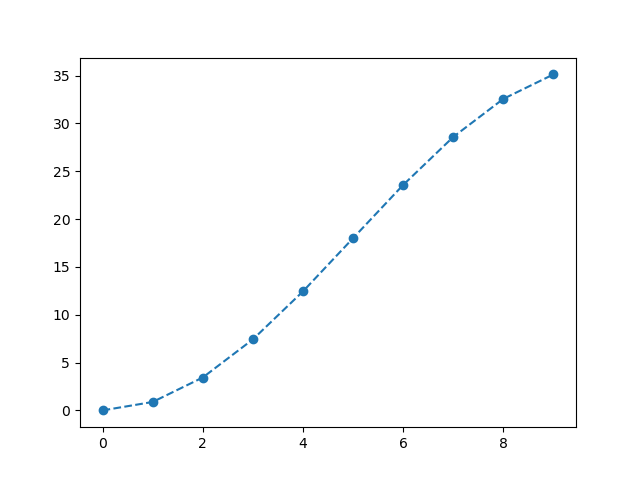

In [4]:
fig = plt.figure()
ax = plt.subplot(111)
plt.spy(K);
ax.set_title('Fill pattern of matrix');
ax.set_ylabel('Row index');
ax.set_xlabel('Column index');
ax.set_aspect('equal')
plt.show()

fig = plt.figure()
d, _ = np.linalg.eig(K)
plt.plot(np.sort( d ), 'o--' );
ax.set_title('Eigenvalues of matrix');
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Value');
plt.show()

After we have verified the assembly was done correctly we can apply boundary conditions. After we have added the boundary conditions we have reduced the number of variables to solve for.

In [5]:
# Boundary values
a = 1
b = 2

values  = np.array([a, b],dtype=np.float64)
indices = np.array([0, N-1], dtype=np.int32)

# F holds the indices of all vertices that are not on the boundary
F = np.setdiff1d(np.arange(N), indices)

for i, (index, value) in enumerate(zip(indices, values)):
    # TODO - Insert boundary conditions into K
    
    # Moving known values to the right hand side
    f[F] -= K[F, index] * value
    f[index] = value
    
    # Inserting boundary conditions into K
    K[index,:] = 0
    K[index,index] = 1

# Initializing y with zeros and boundary values
y = np.zeros(f.shape, dtype=np.float64)
y[indices] = values

# Solving the linear system inside the domain
KFF = K[F,:][:,F]
fF  = f[F]
y[F] = np.linalg.solve(KFF, fF)

We can now plot the solution. We expect a straight line going from a-value to b-value.

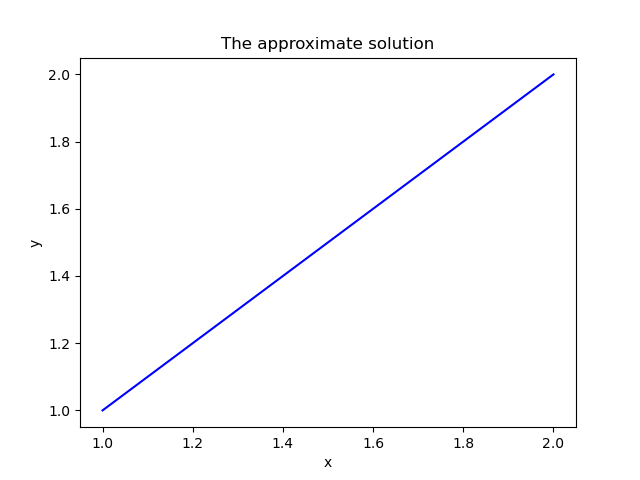

In [6]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(x,y,'b')
ax.set_title('The approximate solution')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# The 2D Poisson Problem solved with linear Finite Element Method
The 2D Poisson problem procedes in nearly the same way except that having both x and y coordinates increases the dimensionality slightly.

We will reuse the beam mesh generator from week 3 to create a computational mesh for the 2D problem

In [9]:
def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

width = 1.0
height = 1.0
I = J = 10
V, T = make_beam_mesh(width,height,(I,J))

We will extend with a little auxiliary function that computes the triangle area for each triangle and returns a vector with all triangle area values.

In [10]:
def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A

A = compute_triangle_areas(V,T)

We now have all pieces in place and can start on computing the local element values followed by our assembly process.

In [11]:
N = len(V) # Total number of nodes in the mesh
E = len(T) # Total number of triangles in the mesh

Ke = np.zeros((E, 3, 3),dtype=np.float64)

# EMBARRASSINGLY PARALLEL
for e in range(E):
    # Get triangle indices
    i = T[e,0]
    j = T[e,1]
    k = T[e,2]
    # Get triangle coordinates
    xi = V[i,0]; yi = V[i,1]
    xj = V[j,0]; yj = V[j,1]
    xk = V[k,0]; yk = V[k,1] 
    
    # TODO - Compute element matrix and store it in Ke array
    A_ijk = A[e]
    
    D_Ni_x = -(yk - yj) / (2 * A_ijk)
    D_Nj_x = -(yi - yk) / (2 * A_ijk)
    D_Nk_x = -(yj - yi) / (2 * A_ijk)
    
    D_Ni_y = (xk - xj) / (2 * A_ijk)
    D_Nj_y = (xi - xk) / (2 * A_ijk)
    D_Nk_y = (xj - xi) / (2 * A_ijk)
    
    D_Ne_x = np.array([D_Ni_x, D_Nj_x, D_Nk_x])
    D_Ne_y = np.array([D_Ni_y, D_Nj_y, D_Nk_y])
    
    element_K = A_ijk * (np.outer(D_Ne_x, D_Ne_x) + np.outer(D_Ne_y, D_Ne_y))
    Ke[e] = element_K
    
K  = np.zeros((N,N),dtype=np.float64) 
f  = np.zeros((N,),dtype=np.float64) 

for e in range(E):
    # Get global triangle vertex indices
    i = T[e,0]
    j = T[e,1]
    k = T[e,2]
    # Local order of vertex coordinates is i, j and k. 
    # This is how local vertex indices (0,1,2) are mapped to global vertex
    # indices
    gidx = [i, j, k]
    # TODO - do assembly of Ke into K
    for p in range(3):
        for q in range(3):
            K[gidx[p], gidx[q]] += Ke[e,p,q]

We visually verify the assembly process by observing the expected symmetry pattern. The eigenvalue analysis should this time show that we have 2 zero eigenvalues.

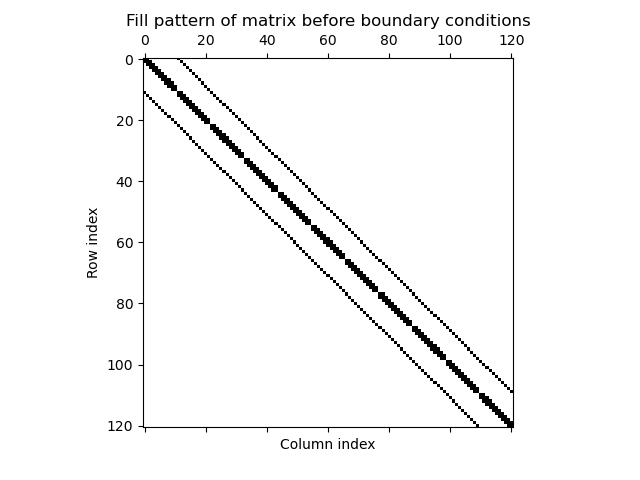

In [12]:
fig = plt.figure()
ax = plt.subplot(111)
plt.spy(K)
ax.set_title('Fill pattern of matrix before boundary conditions')
ax.set_ylabel('Row index')
ax.set_xlabel('Column index')
plt.show()

There are 0 eigenvalues with values of zero or less. 


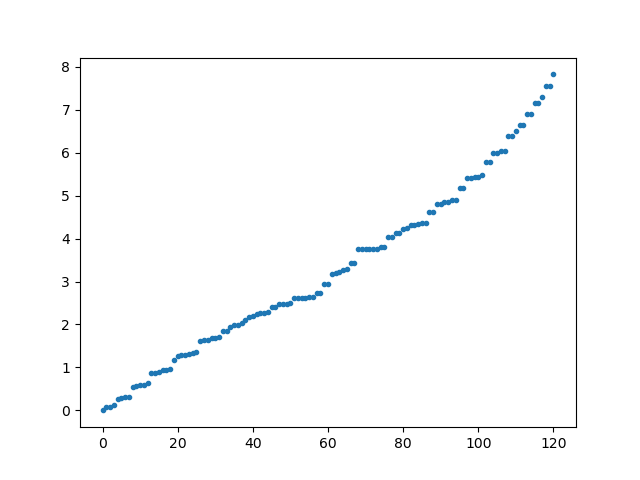

In [13]:
d, _ = np.linalg.eig(K)
d_sort = np.sort(d)
print(f"There are {(d.any() <= 0).sum()} eigenvalues with values of zero or less. ")

fig = plt.figure()
plt.plot(d_sort, '.' )
ax.set_title('Eigenvalues of matrix')
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Value')
plt.show()

We may now proceed as before adding boundary conditions

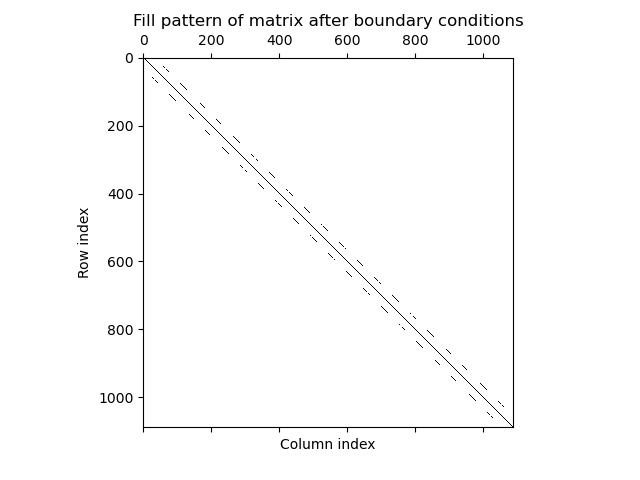

In [ ]:
a = 0
b = 2

left_boundary_points = np.array( np.where(V[:,0] < -width*5/11), dtype=np.int32).flatten()
right_boundary_points = np.array( np.where(V[:,0] > width*5/11), dtype=np.int32).flatten()

left_boudnary_values = np.ones(left_boundary_points.shape, dtype=np.float64)*a
right_boundary_values = np.ones(right_boundary_points.shape, dtype=np.float64)*b
boundary_indices = np.hstack((left_boundary_points, right_boundary_points))
boundary_values  = np.hstack((left_boudnary_values, right_boundary_values))

F = np.setdiff1d(np.arange(N), boundary_indices)

for i, (boundary_index, boundary_value) in enumerate(zip(boundary_indices, boundary_values)):
    # TODO - Insert boundary conditions into K
    
    # Moving known values to the right_boundary_points hand side
    f[F] -= K[F, boundary_index] * boundary_value
    f[boundary_index] = boundary_value

    # Inserting boundary conditions into K
    K[boundary_index,:] = 0
    K[:, boundary_index] = 0
    K[boundary_index,boundary_index] = 1

fig = plt.figure()
ax = plt.subplot(111)
plt.spy(K)
ax.set_title('Fill pattern of matrix after boundary conditions')
ax.set_ylabel('Row index')
ax.set_xlabel('Column index')
plt.show()

In [ ]:
# Initializing y with zeros and boundary values
y = np.zeros(f.shape, dtype=np.float64)
y[boundary_indices] = boundary_values

# Solving the linear system inside the domain
KFF = K[F,:][:,F]
fF  = f[F]
y[F] = np.linalg.solve(KFF, fF)

Finally we can visualize the solution that should show a linear ramp from a to b.

c:\Users\carla\.conda\envs\cmis\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


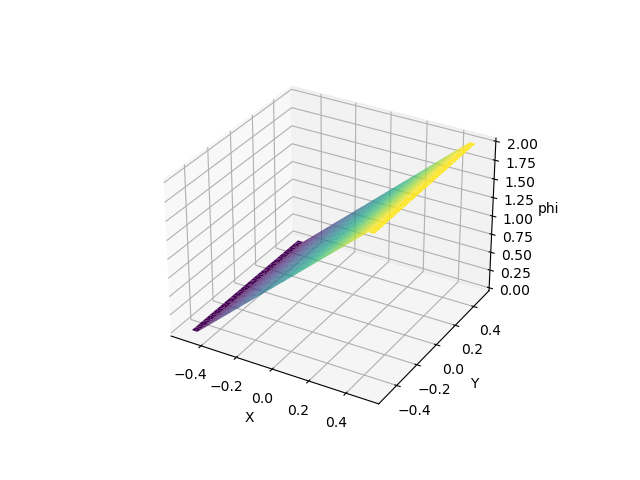

In [ ]:
xs = np.linspace(-width/2, width/2, N)
ys = np.linspace(-height/2, height/2, N)
    
X, Y = np.meshgrid(xs, ys)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(V[:,0],V[:,1],y, cmap='viridis')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("phi")
plt.show()

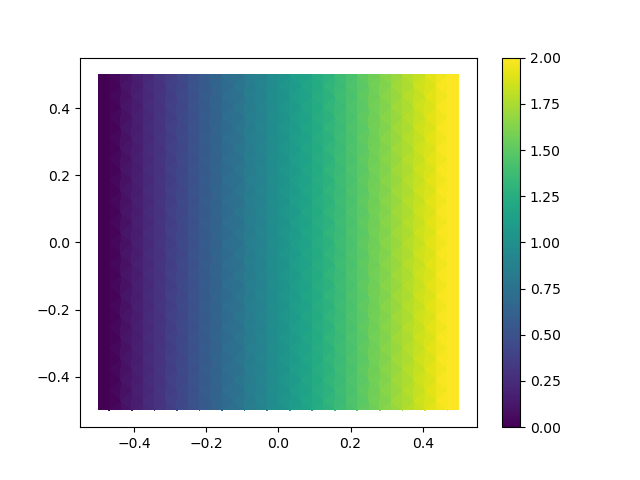

In [ ]:
fig = plt.figure()

plt.tripcolor(V[:,0],V[:,1],T,y)
# plt.triplot(V[:,0],V[:,1],T)
plt.colorbar()
plt.show()

That is all folks